# 生鮮野菜の価格予測 3位のソリューション

In [1]:
%cd "/content/drive/MyDrive/Colab Notebooks/nishika-yasai"

/content/drive/MyDrive/Colab Notebooks/nishika-yasai


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
train = pd.read_csv("data/train.csv")
train["date"] = pd.to_datetime(train["date"], format = "%Y%m%d")
test = pd.read_csv("data/test.csv")
test["date"] = pd.to_datetime(test["date"], format = "%Y%m%d")
traintest = pd.concat([train, test], ignore_index = True)

In [4]:
def show(traintest, kind):
    print(kind)
    plt.figure(figsize = (18, 6))
    sns.scatterplot(
        data = (
            traintest
            .loc[lambda df: df["kind"] == kind, :]
            .loc[lambda df: df["date"] > "2019-07-01", :]
        ),
        x = "date",
        y = "mode_price"
    )
    plt.axvspan(pd.to_datetime("2022-04-17"), pd.to_datetime("2022-04-30"), alpha = 0.2, color = "C0")
    plt.axvspan(pd.to_datetime("2021-04-17"), pd.to_datetime("2021-04-30"), alpha = 0.2, color = "C0")
    plt.axvspan(pd.to_datetime("2020-04-17"), pd.to_datetime("2020-04-30"), alpha = 0.2, color = "C0")
    plt.axvspan(pd.to_datetime("2022-05-01"), pd.to_datetime("2022-05-31"), alpha = 0.2, color = "C1")
    plt.axvspan(pd.to_datetime("2021-05-01"), pd.to_datetime("2021-05-31"), alpha = 0.2, color = "C1")
    plt.axvspan(pd.to_datetime("2020-05-01"), pd.to_datetime("2020-05-31"), alpha = 0.2, color = "C1")
    plt.xlim(pd.to_datetime("2019-07-01"), pd.to_datetime("2022-07-01"))
    plt.show()

## コンペ成績

- 入賞したコンペティション名
    - 生鮮野菜の価格予測
- 最終スコア
    - 12.4598 (暫定：16.1937)
- 最終順位
    - 3位 (暫定：11位)
- ユーザー名
    - maruyama

## 入賞者のバックグラウンド

- 学歴/職歴
    - (オフレコ)
- 上位入賞に役立った経験・知識
    - データ観察の結果から背後にある現象の仮説を立てる経験
    - 分析前にデータの品質を確認する経験
- 参加したきっかけ・理由
    - スキルアップのため (本当は同僚とチームを組む予定だったが多忙で間に合わなかった)
- コンペに費やした時間
    - 半日くらい

## ソリューション概要

- 使用した実行環境・言語・ライブラリ・サービスなど
    - Google Colaboratory
    - Python
- 使用したモデル構築手法 (LightGBM, CNN, etc)
    - 野菜ごとに、前月 or 同月の平均価格を予測値として出力するだけ
    - 機械学習は未使用
- 最も有効だった特徴量・モデル
    - 野菜の種類
- モデルの学習にかかった時間
    - 学習時間はほぼかからない

## このソリューションに至った背景

### データ観察から得た仮説

- (仮説1) 野菜の価格は季節性を持つ。
    - 時期が近ければ価格も近くなる。
    - → 同時期の価格 (前年同月の平均価格など) が予測値としてよく当てはまるはず。
- (仮説2) 天候はその年の価格水準に影響を与える。
    - 天候の影響は既に直前の価格へ織り込まれている。
    - → 直前の価格 (同年前月の平均価格など) が予測値としてよく当てはまるはず。
- (仮説3) 日々の価格変動は天候以外の要因 (産地など) によってもたらされる。
    - 天候データしか与えられていないので日々の価格変動は予測できない。
    - → ざっくり月平均を押さえるべき。

こまつな


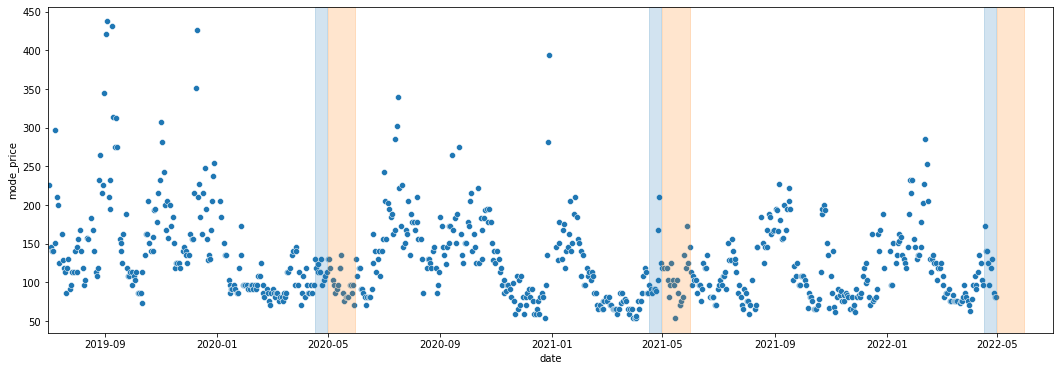

In [5]:
show(traintest, "こまつな")

### 月平均を予測する方法で得られるスコアの試算

月平均を予測する方法を過去10年間に適用してみると……

- 同年同月 (月平均を予測する方法で得られる理論上の最小スコア) は [14.99, 26.87]。
- 同年前月の暫定スコアは 18.15。
- 同年前月と同年同月の比の値は [1.29, 3.12]。
- [18.15 / 3.12, 18.15 / 1.29] = [5.81, 14.06] 程度なら目指せるのでは？


In [6]:
def rmspe(year):
    pred_04 = (
        pd.merge(
            (
                train
                .loc[lambda df: df["kind"].isin(test["kind"]), :]
                .loc[lambda df: df["date"].between(f"{year}-05-01", f"{year}-05-31"), :]
            ),
            (
                train
                .loc[lambda df: df["kind"].isin(test["kind"]), :]
                .loc[lambda df: df["date"].between(f"{year}-04-17", f"{year}-04-30"), :]
                .groupby(["kind"], as_index = False)["mode_price"].mean()
                .rename(columns = {"mode_price": "mode_price_pred"})
            ),
            how = "left",
            on = "kind"
        )
        .assign(spe = lambda df: ((df["mode_price_pred"] - df["mode_price"]) / df["mode_price"]) ** 2)
        ["spe"].mean() ** 0.5 * 100
    )

    pred_05 = (
        pd.merge(
            (
                train
                .loc[lambda df: df["kind"].isin(test["kind"]), :]
                .loc[lambda df: df["date"].between(f"{year}-05-01", f"{year}-05-31"), :]
            ),
            (
                train
                .loc[lambda df: df["kind"].isin(test["kind"]), :]
                .loc[lambda df: df["date"].between(f"{year - 1}-05-01", f"{year - 1}-05-31"), :]
                .groupby(["kind"], as_index = False)["mode_price"].mean()
                .rename(columns = {"mode_price": "mode_price_pred"})
            ),
            how = "left",
            on = "kind"
        )
        .assign(spe = lambda df: ((df["mode_price_pred"] - df["mode_price"]) / df["mode_price"]) ** 2)
        ["spe"].mean() ** 0.5 * 100
    )

    truth = (
        train
        .loc[lambda df: df["kind"].isin(test["kind"]), :]
        .loc[lambda df: df["date"].between(f"{year}-05-01", f"{year}-05-31"), :]
        .assign(mode_price_pred = lambda df: df.groupby(["kind"])["mode_price"].transform(lambda s: s.mean()))
        .assign(spe = lambda df: ((df["mode_price_pred"] - df["mode_price"]) / df["mode_price"]) ** 2)
        ["spe"].mean() ** 0.5 * 100
    )

    return year, pred_04, pred_05, truth

temp = [rmspe(year) for year in range(2012, 2022)]
temp = pd.DataFrame(temp, columns = ["年", "同年前月", "前年同月", "同年同月"])
temp["同年前月 / 同年同月"] = temp["同年前月"] / temp["同年同月"]
temp["前年同月 / 同年同月"] = temp["前年同月"] / temp["同年同月"]
temp[["年", "同年前月", "同年同月", "同年前月 / 同年同月"]]

,年,同年前月,同年同月,同年前月 / 同年同月
0,2012,32.898661,24.018036,1.369748
1,2013,83.953177,26.871692,3.124224
2,2014,33.020336,18.311021,1.803304
3,2015,48.839625,20.894805,2.337405
4,2016,25.407558,16.739143,1.517853
5,2017,27.313841,17.156762,1.592016
6,2018,35.100729,17.848243,1.966621
7,2019,22.367886,14.993024,1.491886
8,2020,60.723911,23.445089,2.590048
9,2021,29.685416,22.885610,1.297121


## ソリューション詳細

野菜を3つのパターンに分け、それぞれのパターンごとに月平均の予測方法を決めた。

- (パターン1) 4月～5月に価格が変化する野菜
    - → 前年同月の平均価格
- (パターン2) 4月～5月に価格が変化する野菜のうち昨年の価格が異常な野菜
    - → 前前年同月の平均価格
- (パターン3) 4月と5月の価格水準が同じ野菜
    - → 同年前月の平均価格


### (パターン1) 4月～5月に価格が変化する野菜

- 概要
    - 旬を迎え価格が下がる夏野菜、旬が終わり価格が上がる冬野菜
- 該当する野菜
    - きゅうり、そらまめ、トマト、ピーマン、ミニトマト、レタス
- 予測値の出し方
    - 前年同月 (2021年5月) の平均価格を予測値として出力する

きゅうり


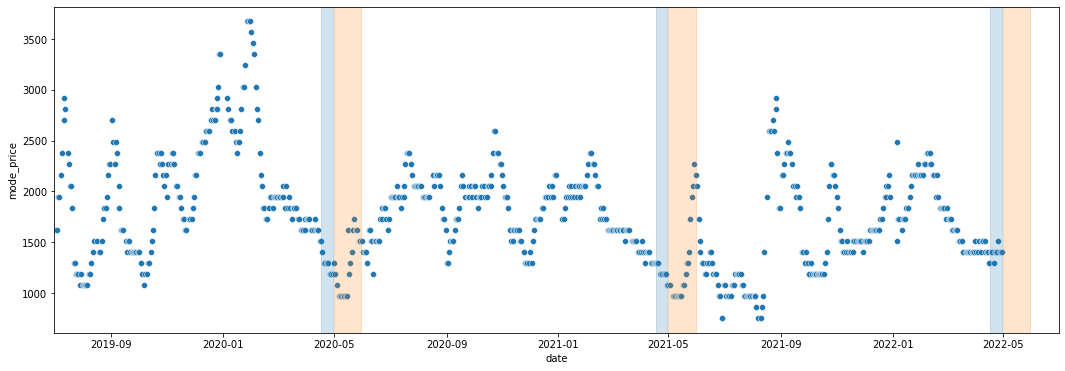

In [7]:
show(traintest, "きゅうり")

### (パターン2) 4月～5月に価格が変化する野菜のうち昨年の価格が異常な野菜

- 概要
    - 豊作や不作により、2021年に暴落や高騰が起きている野菜
- 該当する野菜
    - だいこん、ねぎ、セルリー
- 予測値の出し方
    - 例年通りと思われる前前年同月 (2020年5月) の平均価格を予測値として出力する

ねぎ


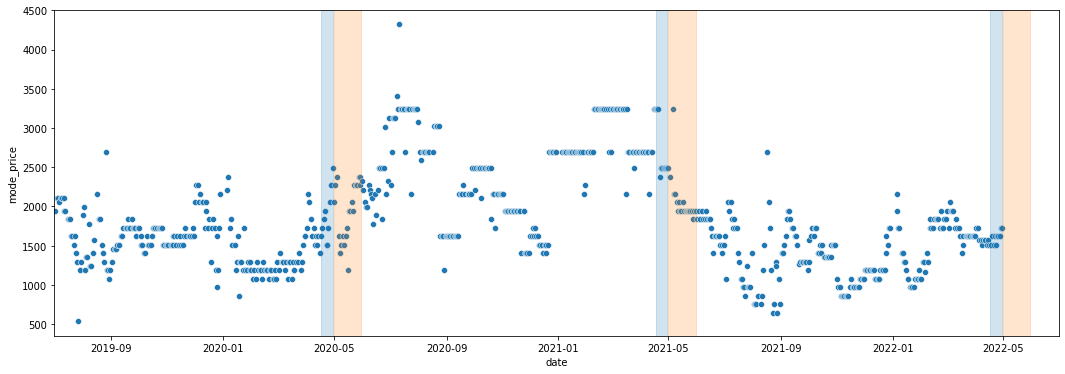

In [8]:
show(traintest, "ねぎ")

### (パターン3) 4月と5月の価格水準が同じ野菜

- 概要
    - パターン1やパターン2に該当しない野菜
- 該当する野菜
    - こまつな、じゃがいも、なましいたけ、にんじん、はくさい、ほうれんそう、キャベツ
- 予測値の出し方
    - 同年前月 (2022年4月) の平均価格を予測値として出力する

こまつな


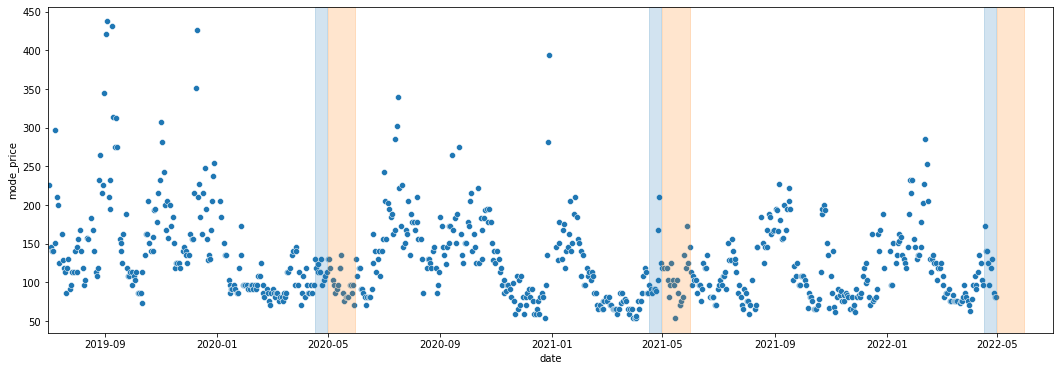

In [9]:
show(traintest, "こまつな")

## このソリューションの課題

- 問題点
    - パターンの判別を分析者の主観に頼っている。
        - 妥当な判別理由を説明しづらい例：レタス (パターン1) とキャベツ (パターン3)
    - パターンの判別基準があいまいだから、予測精度の評価ができない。
- 改善案
    - パターンの判別モデルを作る。
    - パターンの判別モデルを使って、過去データに対して予測精度を評価する。

レタス


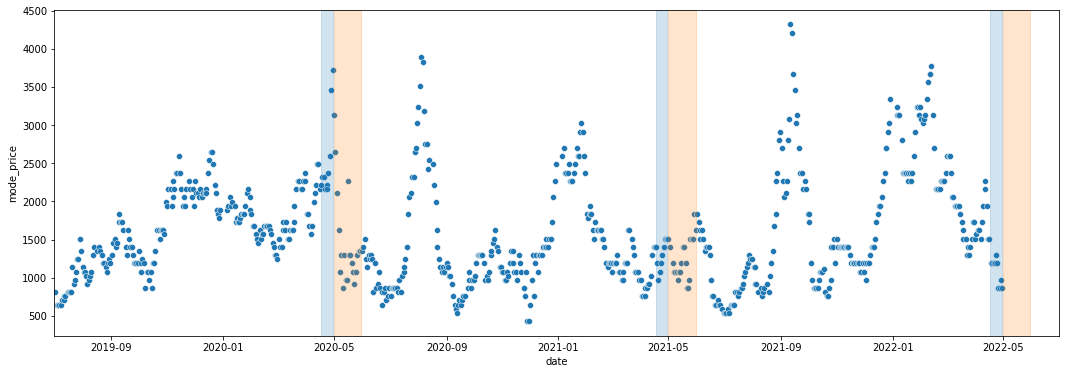

In [10]:
show(traintest, "レタス")

キャベツ


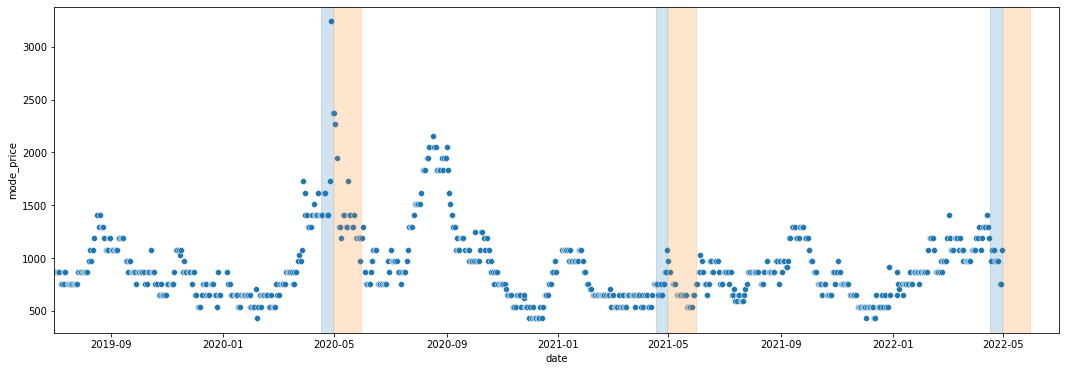

In [11]:
show(traintest, "キャベツ")

## まとめ

- データ観察の結果から、以下の仮説を得た。
    - ざっくり月平均を押さえるべき。
    - 月平均の予測値として、前月 or 同月の平均価格を用いるべき。
- 野菜を3つのパターンに分け、それぞれのパターンごとに月平均の予測方法を決めた。
    - (パターン1) 4月～5月に価格が変化する野菜
        - → 前年同月の平均価格
    - (パターン2) 4月～5月に価格が変化する野菜のうち昨年の価格が異常な野菜
        - → 前前年同月の平均価格
    - (パターン3) 4月と5月の価格水準が同じ野菜
        - → 同年前月の平均価格
- 結果
    - 暫定：16.1937 (11位) → 最終：12.4598 (3位)